In [1]:
import pandas as pd
import pendulum
import matplotlib.pyplot as plt
from pydantic import BaseModel
from flo import DGraph, DNode, DEdge
from dgraph_visualizer import DGraphVisualizer
from named_types import FloParamsHouse0


class SimulationParams(BaseModel):
    # Hourly prices and weather
    unix_start_s: list[int]
    usd_mwh: list[float]
    usd_mwh_alternative: list[float]
    oat_f: list[float]
    wind_speed_mph: list[float]
    # Hardware
    storage_gallons: int
    hp_power_kw: float
    cop_intercept: float
    cop_oat_coeff: float
    cop_min: float
    cop_min_oat_f: float
    # House parameters
    alpha: float
    beta: float
    gamma: float
    intermediate_power_kw: float
    intermediate_rswt_f: float
    dd_power_kw: float
    dd_rswt_f: float
    dd_delta_t_f: float
    initial_top_temp: float
    initial_middle_temp: float
    initial_bottom_temp: float
    initial_thermocline1: float
    initial_thermocline2: float
    # Business
    max_payback_years: int


class Simulator():
    def __init__(self, params: SimulationParams):
        self.params = params
        self.simulate()

    def simulate(self):
        print(f"Simulating {len(self.params.usd_mwh)} hours")

        horizon_hours = len(self.params.usd_mwh)
        
        flo_params = FloParamsHouse0(
            HorizonHours = horizon_hours,
            # Initial state
            InitialTopTempF = int(self.params.initial_top_temp),
            InitialMiddleTempF = int(self.params.initial_middle_temp),
            InitialBottomTempF = int(self.params.initial_bottom_temp),
            InitialThermocline1 = int(self.params.initial_thermocline1),
            InitialThermocline2 = int(self.params.initial_thermocline2),
            # Hourly forecasts
            StartUnixS = self.params.unix_start_s[0],
            LmpForecast = self.params.usd_mwh[:horizon_hours],
            DistPriceForecast = [0]*horizon_hours,
            RegPriceForecast = [0]*horizon_hours,
            OatForecastF = self.params.oat_f[:horizon_hours],
            WindSpeedForecastMph = self.params.wind_speed_mph[:horizon_hours],
            # Hardware
            StorageVolumeGallons = self.params.storage_gallons,
            HpMaxElecKw = self.params.hp_power_kw,
            CopIntercept = self.params.cop_intercept,
            CopOatCoeff = self.params.cop_oat_coeff,
            CopMin = self.params.cop_min,
            CopMinOatF = self.params.cop_min_oat_f,
            HpIsOff=False,
            # House parameters
            AlphaTimes10 = int(self.params.alpha*10),
            BetaTimes100 = int(self.params.beta*100),
            GammaEx6 = int(self.params.gamma*1e6),
            IntermediatePowerKw = self.params.intermediate_power_kw,
            IntermediateRswtF = int(self.params.intermediate_rswt_f),
            DdPowerKw = self.params.dd_power_kw,
            DdRswtF = int(self.params.dd_rswt_f),
            DdDeltaTF = int(self.params.dd_delta_t_f),
        )

        g = DGraph(flo_params)
        g.solve_dijkstra()
        g.find_initial_node()
        v = DGraphVisualizer(g)
        v.plot(top_only=True)

        all_elec_to_next_node = []
        current_node: DNode = g.initial_node
        while current_node.next_node:
            edge_to_next_node: DEdge = [e for e in g.edges[current_node] if e.head==current_node.next_node][0]
            cop = g.params.COP(oat=g.params.oat_forecast[current_node.time_slice])
            elec_to_next_node = edge_to_next_node.hp_heat_out / cop
            all_elec_to_next_node.append(elec_to_next_node)
            current_node = current_node.next_node
        
        self.total_kwhe_used = round(sum(all_elec_to_next_node), 2)
        self.total_cost_usd = round(sum([x*y/1000 for x,y in zip(all_elec_to_next_node, self.params.usd_mwh)]), 2)

        average_usd_mwh_paid = self.total_cost_usd / self.total_kwhe_used * 1000
        average_alternative_usd_mwh = sum(self.params.usd_mwh_alternative)/len(self.params.usd_mwh_alternative)
        relative_decrease = (average_usd_mwh_paid - average_alternative_usd_mwh) / average_alternative_usd_mwh
        would_have_paid_usd = self.total_kwhe_used/1000 * average_alternative_usd_mwh
        total_savings = would_have_paid_usd - self.total_cost_usd
        max_system_cost_usd = total_savings * self.params.max_payback_years

        print(f"\nAverage alternative price during period: {round(average_alternative_usd_mwh,2)} USD/MWh")
        print(f"Average price paid during period: {round(average_usd_mwh_paid,2)} USD/MWh ({round(relative_decrease*100,1)}%)")

        print(f"\nPaid {round(self.total_cost_usd,2)} USD for {round(self.total_kwhe_used/1000,2)} MWh")
        print(f"Would have paid {round(would_have_paid_usd,2)} USD for {round(self.total_kwhe_used/1000,2)} MWh")
        print(f"=> Total savings: {round(total_savings,1)} USD")
        print(f"=> The system would need to cost {round(max_system_cost_usd)} USD to break even in {self.params.max_payback_years} years")

Simulating 4805 hours
Loaded super graph in 0.3 seconds
Built a graph with 4805 layers of 6372 nodes each
Created nodes in 34.4 seconds
Built edges for hour 0
Built edges for hour 1
Built edges for hour 2
Built edges for hour 3
Built edges for hour 4
Built edges for hour 5
Built edges for hour 6
Built edges for hour 7
Built edges for hour 8
Built edges for hour 9
Built edges for hour 10
Built edges for hour 11
Built edges for hour 12
Built edges for hour 13
Built edges for hour 14
Built edges for hour 15
Built edges for hour 16
Built edges for hour 17
Built edges for hour 18
Built edges for hour 19
Built edges for hour 20
Built edges for hour 21
Built edges for hour 22
Built edges for hour 23
Built edges for hour 24
Built edges for hour 25
Built edges for hour 26
Built edges for hour 27
Built edges for hour 28
Built edges for hour 29
Built edges for hour 30
Built edges for hour 31
Built edges for hour 32
Built edges for hour 33
Built edges for hour 34
Built edges for hour 35
Built edge

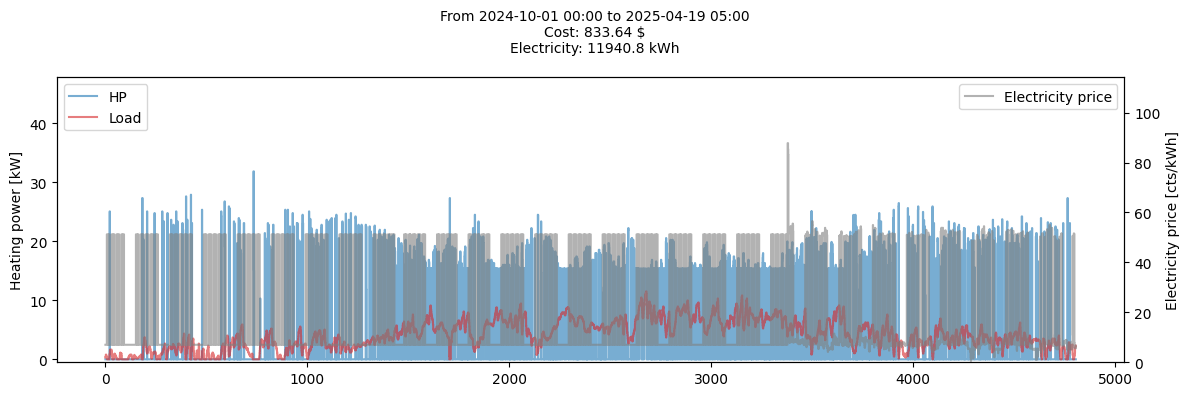


Average alternative price during period: 160.0 USD/MWh
Average price paid during period: 69.81 USD/MWh (-56.4%)

Paid 833.64 USD for 11.94 MWh
Would have paid 1910.52 USD for 11.94 MWh
=> Total savings: 1076.9 USD
=> The system would need to cost 10769 USD to break even in 10 years


In [2]:
df = pd.read_csv('simulation_data.csv')[1*24*30:].reset_index(drop=True)

params = SimulationParams(
    # Hourly prices and weather
    unix_start_s = list(df['hour_start_s']),
    usd_mwh = list(df['usd_mwh']),
    usd_mwh_alternative = [160]*len(df),
    oat_f = list(df['oat_f']),
    wind_speed_mph = list(df['ws_mph']),
    # Hardware
    storage_gallons = 360,
    hp_power_kw = 11,
    cop_intercept = 1.02,
    cop_oat_coeff = 0.0257,
    cop_min = 1.4,
    cop_min_oat_f = 15,
    # House parameters
    alpha = 9.3,
    beta = -0.17,
    gamma = 0.0015,
    intermediate_power_kw = 1.5,
    intermediate_rswt_f = 100,
    dd_power_kw = 10.75,
    dd_rswt_f = 160,
    dd_delta_t_f = 20,
    initial_top_temp = 120,
    initial_middle_temp = 100,
    initial_bottom_temp = 100,
    initial_thermocline1 = 1,
    initial_thermocline2 = 1,
    # Business
    max_payback_years = 10,
)

s = Simulator(params)